In [99]:
import json
import os
import re
import tqdm
import random
from PIL import Image

%matplotlib inline
from pycocotools.coco import COCO
from pycocotools import mask as cocomask
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import random
import os
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [89]:
IMAGES_FOLDER_PATH="/mount/SDB/myfoodrepo-seth/myfoodrepo-images/images"
ANNOTATIONS_PATH="/mount/SDB/myfoodrepo-seth/prepared_annotations/coco_annotations_assignments_2018_08_02_14-29-36.json"

OUTPUT_DIRECCTORY = "/mount/SDE/myfoodrepo/mohanty/myfoodrepo-mask-rcnn/data"

TRAIN_PERCENT = 0.8
VAL_PERCENT = 0.1
TEST_PERCENT = 1 - (TRAIN_PERCENT + VAL_PERCENT)

In [90]:
# Build index of image_id to filepath
image_path_map = {}
rootDir = IMAGES_FOLDER_PATH
for dirName, subdirList, fileList in tqdm.tqdm(os.walk(rootDir, topdown=False)):
    for fname in fileList:
        if len(re.findall("^\d+.jpg$", fname))>0:
            #print('.', end='', flush=True)
            image_path_map[fname.replace(".jpg", "")] = os.path.join(dirName, fname)
        

595it [00:00, 786.92it/s]


In [91]:
annotations = json.loads(open(ANNOTATIONS_PATH).read())

In [92]:
# Index annotations by image_id
annotations_by_image_id = {}
for item in annotations:
    try:
        annotations_by_image_id[item["image_id"]].append(item)
    except:
        annotations_by_image_id[item["image_id"]] = [item]

In [93]:
images_in_annotations = list(annotations_by_image_id.keys())
random.shuffle(images_in_annotations)

TRAIN_IDX = int(len(images_in_annotations) * TRAIN_PERCENT)
VAL_IDX = TRAIN_IDX + int(len(images_in_annotations) * VAL_PERCENT)
TEST_IDX = len(images_in_annotations)

TRAIN_IMAGES = images_in_annotations[0:TRAIN_IDX]
VAL_IMAGES = images_in_annotations[TRAIN_IDX:VAL_IDX]
TEST_IMAGES = images_in_annotations[VAL_IDX:TEST_IDX]

In [199]:
def generate_image_object(_image, IMAGES_DIR):
    image_path = image_path_map[_image]
    target_filename = "{}.jpg".format(_image.zfill(12))
    _image_object = {}
    _image_object["id"] = int(_image)
    _image_object["file_name"] = target_filename
    im = Image.open(image_path)
    width, height = im.size
    _image_object["width"] = width
    _image_object["height"] = height
    im.save(os.path.join(IMAGES_DIR, target_filename))
    im.close()
    return _image_object
    
def generate_annotations_file(IMAGES, OUTPUT_DIRECTORY):
    d = {}
    d["info"] = {'contributor': 'spMohanty', 'about': 'My Food Repo dataset', 'date_created': '04/08/2018', 'description': 'Annotations on myfoodrepo dataset', 'version': '1.0', 'year': 2018}
    d["categories"] = [{'id': 100, 'name': 'food', 'supercategory': 'food'}]
    d["images"] = []
    d["annotations"] = []
    
    IMAGES_DIR = os.path.join(OUTPUT_DIRECTORY, "images")
    if not os.path.exists(IMAGES_DIR):
        os.makedirs(IMAGES_DIR)
    
    annotation_count = 0
    for _image in tqdm.tqdm(IMAGES):
        try:
            image_path = image_path_map[_image]
        except:
            print("Errorr Processing : ", _image)
            continue
        
        _image_object = generate_image_object(_image, IMAGES_DIR)
        assert _image_object != None
        d["images"].append(_image_object)
        for _annotation in annotations_by_image_id[_image]:
            _annotation["id"] = annotation_count
            annotation_count += 1
            _annotation["image_id"] = int(_image)
            d["annotations"].append(_annotation)
    fp = open(os.path.join(OUTPUT_DIRECTORY, "annotations.json"), "w")
    fp.write(json.dumps(d))
    fp.close()
    print(len(d["images"]))
    print(d["images"][0])

   
generate_annotations_file(TRAIN_IMAGES, os.path.join(OUTPUT_DIRECCTORY, "myfoodrepo-train"))
generate_annotations_file(VAL_IMAGES, os.path.join(OUTPUT_DIRECCTORY, "myfoodrepo-val"))
generate_annotations_file(TEST_IMAGES, os.path.join(OUTPUT_DIRECCTORY, "myfoodrepo-test"))

 86%|████████▋ | 7935/9176 [03:47<00:35, 34.94it/s]

Errorr Processing :  1027676 - Copie


  0%|          | 5/1147 [00:00<00:27, 41.08it/s]

9175
{'id': 1059042, 'file_name': '000001059042.jpg', 'width': 512, 'height': 512}


  1%|          | 9/1148 [00:00<00:13, 83.71it/s]

1147
{'id': 1537303, 'file_name': '000001537303.jpg', 'width': 512, 'height': 512}


100%|██████████| 1148/1148 [00:12<00:00, 92.95it/s]


1148
{'id': 1518315, 'file_name': '000001518315.jpg', 'width': 382, 'height': 512}


loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
[{'id': 100, 'name': 'food', 'supercategory': 'food'}]
{'id': 1252372, 'file_name': '000001252372.jpg', 'width': 512, 'height': 384}


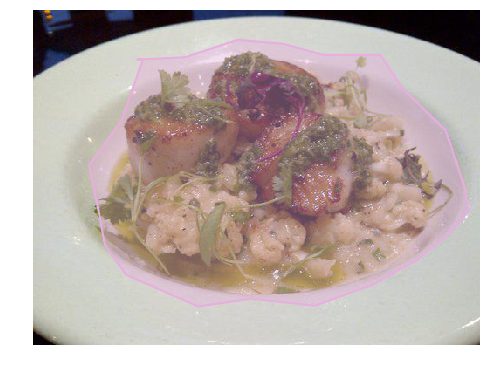

In [203]:
"""
Test if the annotations work properly
!pip install git+https://github.com/crowdai/coco.git#subdirectory=PythonAPI
"""

def test_annotations(subdir_name):
    IMAGES_DIRECTORY = "../data/{subdir_name}/images".format(subdir_name=subdir_name)
    ANNOTATIONS_PATH = "../data/{subdir_name}/annotations.json".format(subdir_name=subdir_name)
    
    coco = COCO(ANNOTATIONS_PATH)
    category_ids = coco.loadCats(coco.getCatIds())
    print(category_ids)
    image_ids = coco.getImgIds(catIds=coco.getCatIds())
    random_image_id = random.choice(image_ids)
    img = coco.loadImgs(random_image_id)[0]
    print(img)
    image_path = os.path.join(IMAGES_DIRECTORY, img["file_name"])
    I = io.imread(image_path)
    
    annotation_ids = coco.getAnnIds(imgIds=img['id'])
    annotations = coco.loadAnns(annotation_ids)
    plt.imshow(I); plt.axis('off')
    coco.showAnns(annotations)

#test_annotations("myfoodrepo-train")
#test_annotations("myfoodrepo-val")
test_annotations("myfoodrepo-test")